In [30]:
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
import geopandas as gpd
from skimage.segmentation import slic, mark_boundaries
import matplotlib.pyplot as plt
from rasterstats import zonal_stats

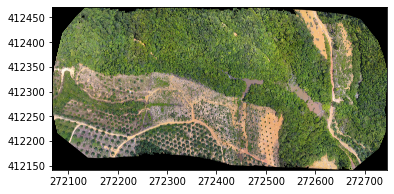

<AxesSubplot:>

In [5]:
image = rasterio.open('UAV_orthophoto (3).tif')
show(image)

In [6]:
AOI = gpd.read_file('AOI.shp')
shape = AOI.geometry

In [7]:
with rasterio.open("UAV_orthophoto (3).tif") as src:
    out_image, out_transform = rasterio.mask.mask(src, shape, crop=True)
    out_meta = src.meta


out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open("image_new.tif", "w", **out_meta) as image:
    image.write(out_image)

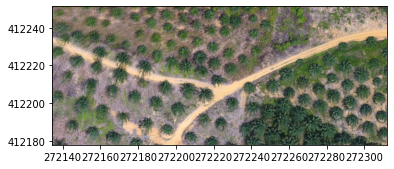

In [8]:
image = rasterio.open('image_new.tif')
show(image)
img = image.read([1,2,3])

In [9]:
img.shape

(3, 1433, 3465)

In [10]:
img = img.transpose(1,2,0)

In [11]:
img.shape

(1433, 3465, 3)

In [12]:
segments = slic(img, n_segments=1000, compactness=20, multichannel=True, start_label=1)

In [13]:
segments.shape

(1433, 3465)

In [14]:
segments

array([[  1,   1,   1, ...,  42,  42,  42],
       [  1,   1,   1, ...,  42,  42,  42],
       [  1,   1,   1, ...,  42,  42,  42],
       ...,
       [881, 881, 881, ..., 918, 918, 918],
       [881, 881, 881, ..., 918, 918, 918],
       [881, 881, 881, ..., 918, 918, 918]])

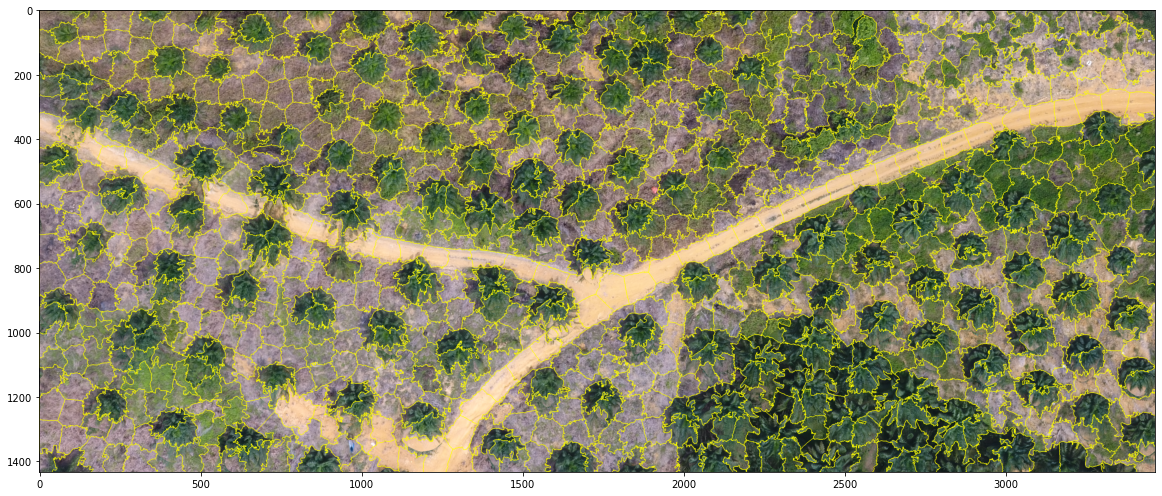

In [14]:
plt.figure(figsize = (20,10))
plt.imshow(mark_boundaries(img, segments))

In [15]:
img_seg = mark_boundaries(img, segments)


In [16]:
img_seg = img_seg.transpose(2,0,1)

In [17]:
img_seg.shape

(3, 1433, 3465)

In [18]:
type(segments)

numpy.ndarray

In [19]:
#save as .tif

with rasterio.open('image_new.tif') as src_dataset:

    profile = src_dataset.profile

    profile.update(
        count=1,
        compress='lzw')

    with rasterio.open('segments.tif', 'w', **profile) as dst:
        dst.write(segments, 1)

In [20]:
segments.shape

(1433, 3465)

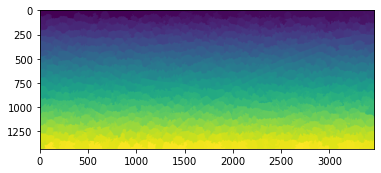

<AxesSubplot:>

In [21]:
show(segments)

In [22]:
!gdal_polygonize.py segments.tif segments.shp

Creating output segments.shp of format ESRI Shapefile.
0...10...20...30...40...50...60...70...80...90...100 - done.


In [106]:
segments_shp = gpd.read_file('segments.shp')
segments_shp

,DN,geometry
0,5,"POLYGON ((272150.701 412251.334, 272155.516 41..."
1,17,"POLYGON ((272200.180 412251.334, 272205.660 41..."
2,19,"POLYGON ((272210.578 412251.334, 272218.824 41..."
3,15,"POLYGON ((272192.138 412251.334, 272196.799 41..."
4,25,"POLYGON ((272241.207 412251.334, 272247.968 41..."
...,...,...
946,141,"POLYGON ((272174.980 412183.980, 272175.082 41..."
947,161,"POLYGON ((272219.080 412182.853, 272219.234 41..."
948,164,"POLYGON ((272237.366 412182.802, 272237.570 41..."
949,159,"POLYGON ((272268.302 412182.904, 272268.610 41..."


In [107]:
stats = zonal_stats('segments.shp', 'image_new.tif')
stats[1]

/home/dom/miniconda3/envs/obia/lib/python3.9/site-packages/rasterstats/io.py:302: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


{'min': 15.0, 'max': 125.0, 'mean': 67.75344563552834, 'count': 4571}

In [108]:
stat_mean = []
for stat in stats:
    stat_mean.append(stat['mean'])

In [109]:
segments_shp['mean_brightness'] = stat_mean


In [110]:
segments_shp

,DN,geometry,mean_brightness
0,5,"POLYGON ((272150.701 412251.334, 272155.516 41...",93.670690
1,17,"POLYGON ((272200.180 412251.334, 272205.660 41...",67.753446
2,19,"POLYGON ((272210.578 412251.334, 272218.824 41...",136.768461
3,15,"POLYGON ((272192.138 412251.334, 272196.799 41...",127.416362
4,25,"POLYGON ((272241.207 412251.334, 272247.968 41...",70.483863
...,...,...,...
946,141,"POLYGON ((272174.980 412183.980, 272175.082 41...",143.417568
947,161,"POLYGON ((272219.080 412182.853, 272219.234 41...",57.921281
948,164,"POLYGON ((272237.366 412182.802, 272237.570 41...",61.085903
949,159,"POLYGON ((272268.302 412182.904, 272268.610 41...",34.628145


In [141]:
#classfiy by brightness
class_list = []

for value in segments_shp['mean_brightness']:
    if value <= 65:
        class_list.append('shadow')
    if 65 < value < 130:
        class_list.append('trees')
    if value >= 130:
        class_list.append('backround')
        
segments_shp['class'] = class_list
segments_shp.to_file('classified_segments.shp')

<AxesSubplot:>

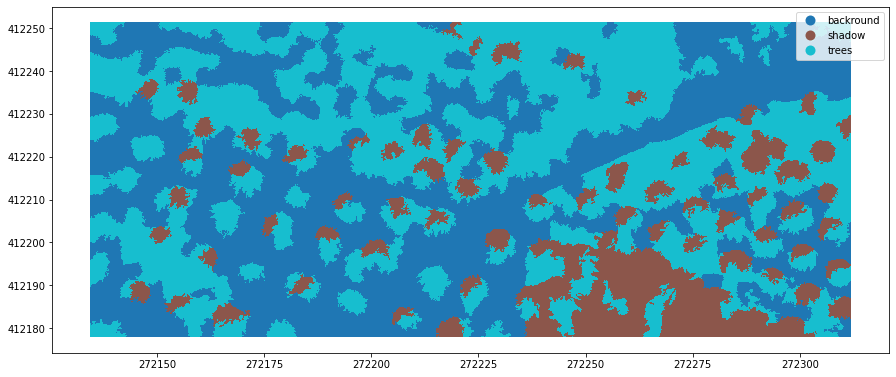

In [146]:
segments_shp.plot('class', legend=True, figsize=(15,15))


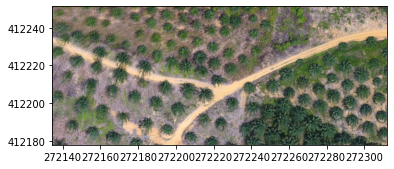

<AxesSubplot:>

In [148]:
show(image)